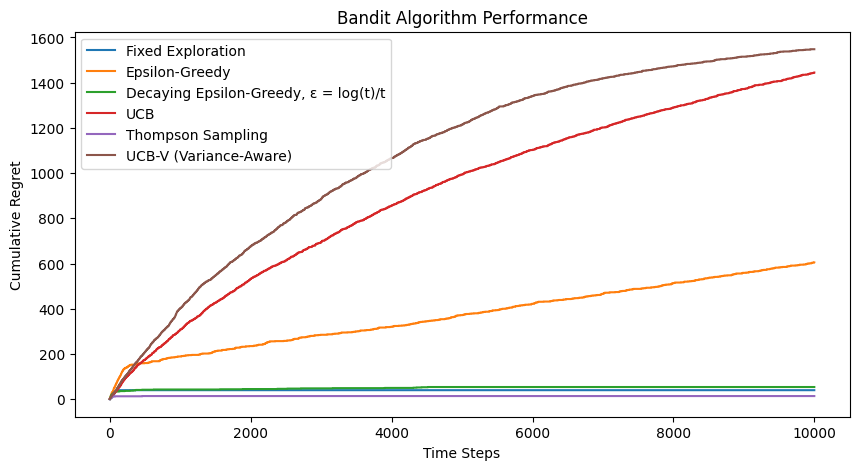

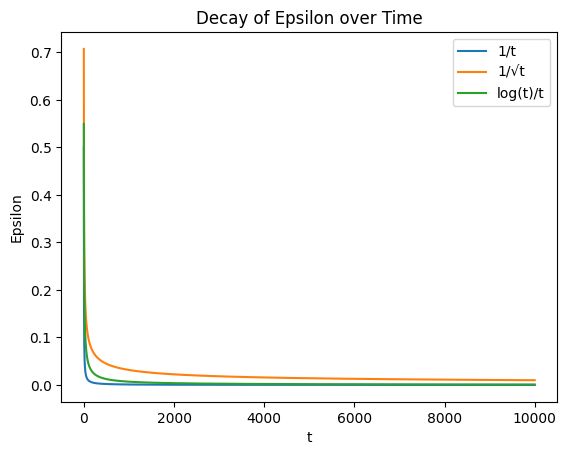

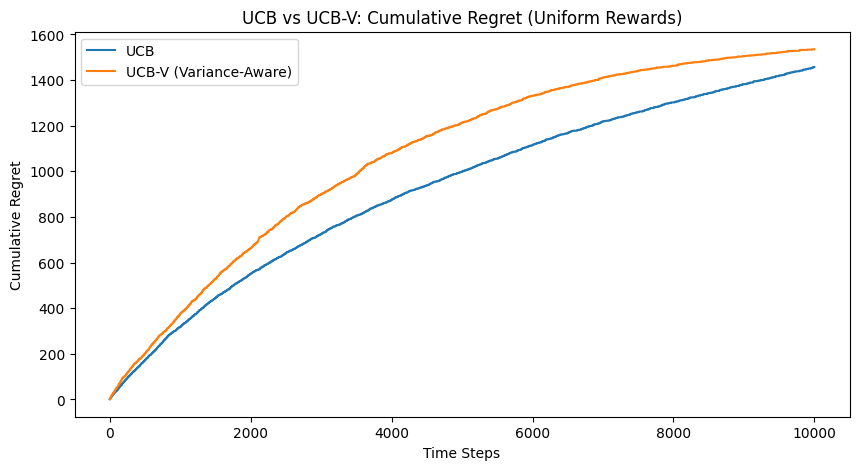

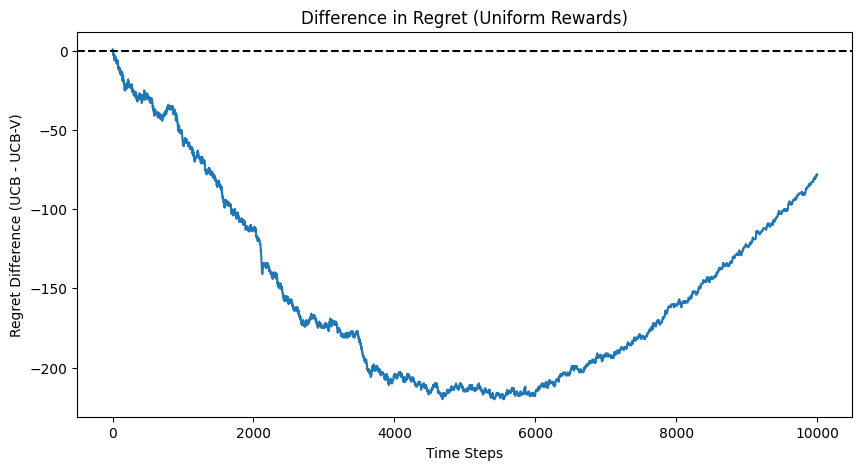

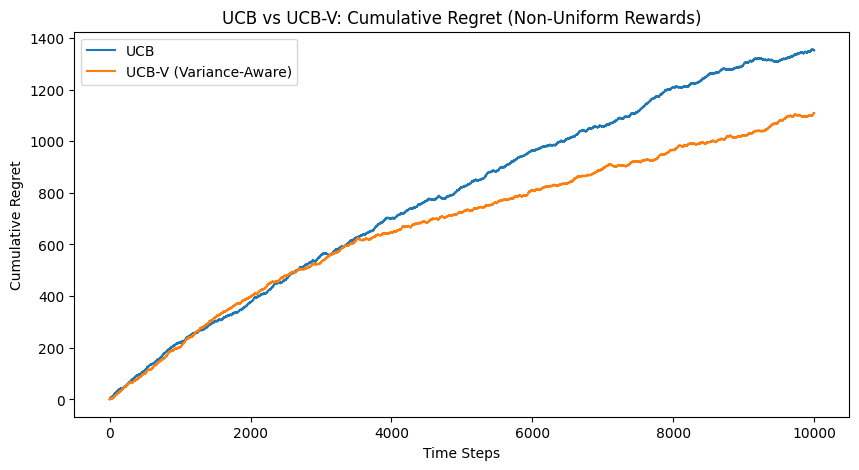

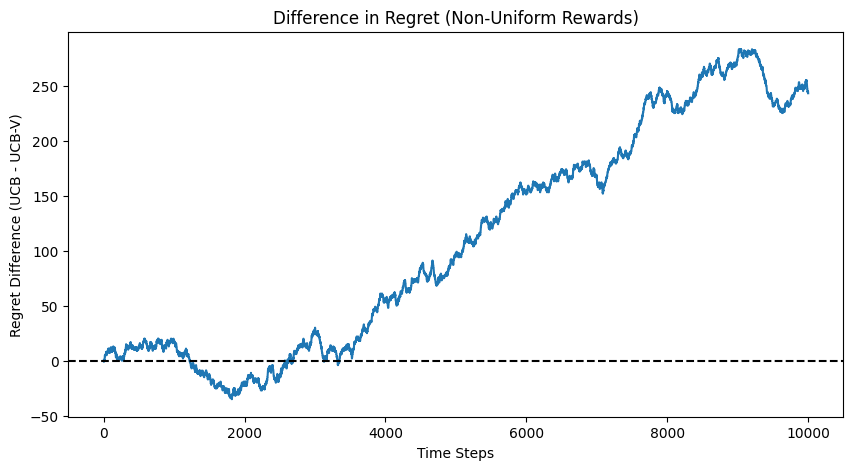

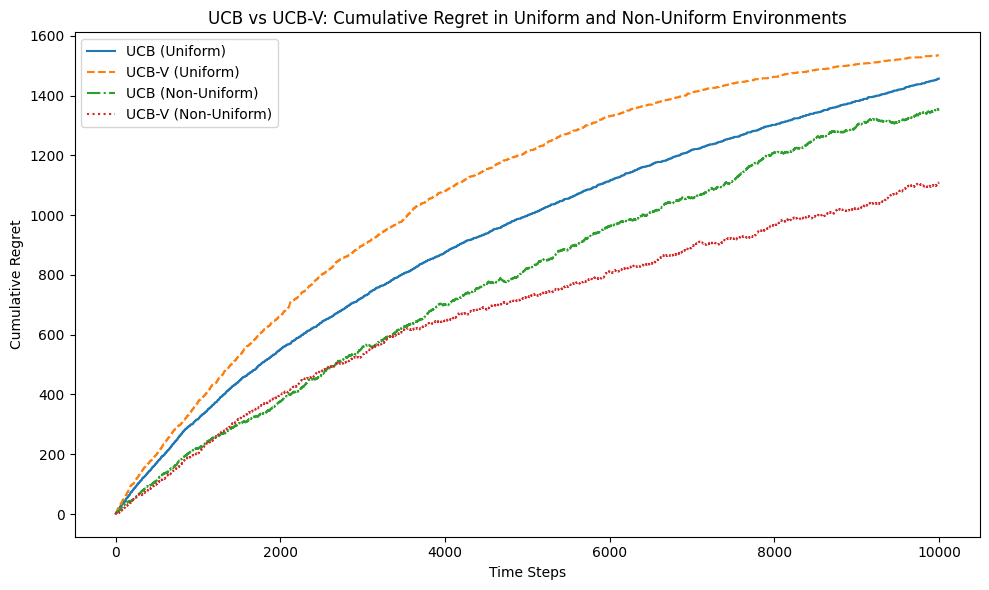

TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.
TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.
TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Bandit Environment
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        self.num_arms = num_arms
        self.reward_means = reward_means

    def pull_arm(self, arm):
        return np.random.binomial(1, self.reward_means[arm])  # Bernoulli rewards

# ==========================
# Fixed Exploration Then Exploitation (TODO: Implement switching strategy)
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        # Choose an arm randomly, explore to learn which arm is the best
        if self.t <= self.exploration_steps:  
            return np.random.randint(self.num_arms)
        else:
        # Choose the best-known arm, exploit the knowledge to earn more
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy Algorithm (TODO: Complete update function)
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        # Explore if the random number is < epsilon
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        # Otherwise exploit: pick the arm with the highest average reward
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration (TODO: Complete decay schedule and compare schedules)
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule  # Function for epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        # Explore if the random number is < epsilon
        if np.random.random() < epsilon:
            return np.random.randint(self.num_arms)
        # Otherwise exploit: pick the arm with the highest average reward
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB Algorithm (TODO: Complete selection function)
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        return np.argmax(self.values + self.c * np.sqrt(np.log(self.t)/(self.counts + 0.00001)))
        # Differences from the theory (slides):
        # confidence bound: sqrt(2*log*T/n_i) 
        # constant: fixed (2, derived from Hoeffding)
        # log term: fixed time horizon T
        # 0.00001 to avoid 0

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Thompson Sampling Algorithm (TODO: Implement Thompson Sampling)
# ==========================
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)

    def select_arm(self):
        samples = np.random.beta(self.successes + 1, self.failures + 1)
        return np.argmax(samples)

    def update(self, arm, reward):
        if reward == 1:
            self.successes[arm] += 1
        else:
            self.failures[arm] += 1

# ==========================
# UCB-V
# ==========================

class UCB_V:
    def __init__(self, num_arms, c=2):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.squared_values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.num_arms:
            return self.t - 1
        ucb_values = np.zeros(self.num_arms)
        for i in range(self.num_arms):
            mean = self.values[i]
            count = self.counts[i]
            variance = self.squared_values[i] / count - mean ** 2 if count > 0 else 0
            bonus = self.c * np.sqrt((2 * np.log(self.t) * max(variance, 1e-6)) / count)
            bonus += (3 * np.log(self.t)) / count
            ucb_values[i] = mean + bonus
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.squared_values[arm] += reward ** 2
        self.t += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    bandit = bandit_class(**bandit_params)
    regrets = []
    optimal_reward = max(env.reward_means)

    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        regret = optimal_reward - reward
        regrets.append(regret)

    return np.cumsum(regrets)

# ==========================
# Running Experiments
# ==========================
num_arms = 10
reward_means = np.linspace(0, 1, num_arms)  # Linearly spaced rewards
env = BanditEnvironment(num_arms, reward_means)
num_steps = 10000

# Define epsilon schedule
def epsilon_schedule_1(t):
    return 1 / (t + 1)

def epsilon_schedule_2(t):
    return 1 / np.sqrt(t + 1)

def epsilon_schedule_3(t):
    return np.log (t + 2) / (t+1)

# Plot setup
plt.figure(figsize=(10,5))

# Run and plot Fixed Exploration Then Exploitation
fixed_exploration_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': 100}, env, num_steps)
plt.plot(fixed_exploration_regret, label='Fixed Exploration')

# Run and plot ε-Greedy
epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': 0.1}, env, num_steps)
plt.plot(epsilon_greedy_regret, label='Epsilon-Greedy')

# Run and plot Decaying ε-Greedy, ε = 1/t
# decaying_epsilon_greedy_regret_1 = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_1}, env, num_steps)
# plt.plot(decaying_epsilon_greedy_regret_1, label='Decaying Epsilon-Greedy, ε = 1/t')

# Run and plot Decaying ε-Greedy, ε = 1/√t
# decaying_epsilon_greedy_regret_2 = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_2}, env, num_steps)
# plt.plot(decaying_epsilon_greedy_regret_2, label='Decaying Epsilon-Greedy, ε = 1/√t')

# Run and plot Decaying ε-Greedy, ε = log(t)/t
decaying_epsilon_greedy_regret_3 = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule_3}, env, num_steps)
plt.plot(decaying_epsilon_greedy_regret_3, label='Decaying Epsilon-Greedy, ε = log(t)/t')

# Run and plot UCB
ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucb_regret, label='UCB')

# Run and plot Thompson Sampling
thompson_regret = run_experiment(ThompsonSampling, {'num_arms': num_arms}, env, num_steps)
plt.plot(thompson_regret, label='Thompson Sampling')

# Run and plot UCB-V (Variance-Aware UCB)
ucbv_regret = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env, num_steps)
plt.plot(ucbv_regret, label='UCB-V (Variance-Aware)')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.title("Bandit Algorithm Performance")
plt.show()

ts = np.arange(1, num_steps + 1)
plt.figure()
plt.plot([epsilon_schedule_1(t) for t in ts], label='1/t')
plt.plot([epsilon_schedule_2(t) for t in ts], label='1/√t')
plt.plot([epsilon_schedule_3(t) for t in ts], label='log(t)/t')
plt.legend()
plt.title("Decay of Epsilon over Time")
plt.xlabel("t")
plt.ylabel("Epsilon")
plt.show()

# ==========================
# NEW: UCB vs UCB-V using initial uniform rewards
# ==========================
ucb_regret_uniform = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env, num_steps)
ucbv_regret_uniform = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env, num_steps)

# NEW Plot 1: Cumulative Regret (Uniform Rewards)
plt.figure(figsize=(10, 5))
plt.plot(ucb_regret_uniform, label='UCB')
plt.plot(ucbv_regret_uniform, label='UCB-V (Variance-Aware)')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("UCB vs UCB-V: Cumulative Regret (Uniform Rewards)")
plt.legend()
plt.show()

# NEW Plot 2: Regret Difference (UCB - UCB-V)
plt.figure(figsize=(10, 5))
plt.plot(ucb_regret_uniform - ucbv_regret_uniform)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Regret Difference (UCB - UCB-V)")
plt.title("Difference in Regret (Uniform Rewards)")
plt.show()

# ==========================
# NEW: Non-uniform reward means for realistic setup
# ==========================
reward_means_non_uniform = np.array([0.1, 0.15, 0.3, 0.25, 0.5, 0.55, 0.4, 0.45, 0.7, 0.65])
env_non_uniform = BanditEnvironment(num_arms, reward_means_non_uniform)

# ==========================
# NEW: Compare UCB and UCB-V under non-uniform reward distribution
# ==========================
ucb_regret_nu = run_experiment(UCB, {'num_arms': num_arms, 'c': 4}, env_non_uniform, num_steps)
ucbv_regret_nu = run_experiment(UCB_V, {'num_arms': num_arms, 'c': 4}, env_non_uniform, num_steps)

# NEW Plot 1: Cumulative Regret
plt.figure(figsize=(10, 5))
plt.plot(ucb_regret_nu, label='UCB')
plt.plot(ucbv_regret_nu, label='UCB-V (Variance-Aware)')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("UCB vs UCB-V: Cumulative Regret (Non-Uniform Rewards)")
plt.legend()
plt.show()

# NEW Plot 2: Regret Difference
plt.figure(figsize=(10, 5))
plt.plot(ucb_regret_nu - ucbv_regret_nu)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Time Steps")
plt.ylabel("Regret Difference (UCB - UCB-V)")
plt.title("Difference in Regret (Non-Uniform Rewards)")
plt.show()

plt.figure(figsize=(10, 6))

# Uniform reward setting
plt.plot(ucb_regret_uniform, label='UCB (Uniform)', linestyle='-')
plt.plot(ucbv_regret_uniform, label='UCB-V (Uniform)', linestyle='--')

# Non-uniform reward setting
plt.plot(ucb_regret_nu, label='UCB (Non-Uniform)', linestyle='-.')
plt.plot(ucbv_regret_nu, label='UCB-V (Non-Uniform)', linestyle=':')

plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.title("UCB vs UCB-V: Cumulative Regret in Uniform and Non-Uniform Environments")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================
# Instructions for Students
# ==========================
print("TODO: Complete the missing functions for Fixed-Exploration-Greedy, Epsilon-Greedy, Decaying Epsilon-Greedy, UCB, and Thompson Sampling.")
print("TODO: Implement and compare different epsilon schedules (e.g., 1/t, 1/sqrt(t), log(t)/t). Discuss the impact on exploration and cumulative regret in your report.")
print("TODO: Answer the questions in the assignment and conduct the necessary experiments to answer them.")
